# 2005 UD Polarimetric Phase Curve Fitting

The dataset is composed of two components:

1. MSI data obtained in this work.
2. The data from [Devogele](https://ui.adsabs.harvard.edu/abs/2020PSJ.....1...15D/abstract), revised by Jooyeon Geem after retrieving the original FITS data (2021 Jan-Mar). Also the data at the largest phase angle (α=106.47˚) is analyzed.

**Note**

Error bars are updated by
```python
dats["dPr"] = np.max(np.array([dats["Pr"]*0.05, [0.1]*len(dats), dats["dPr"]]).T, axis=1)
```
in ``polutil2005ud.py``.

As a part of the publication of IshiguroM+ 2019 (in prep), here I provide full of the analysis code.

## 1. Installation

### 1-1. pymc3
On terminal (Anaconda Prompt or Git Bash on windows)
```
$ conda install pymc3 theano=1.0.4 -c conda-forge
```
See the [issue here](https://github.com/pymc-devs/pymc3/issues/3340) if you encounter problems afterwards.

## 2. Explaining Packages Used
In the code below, I used ``pymc3`` and ``scipy.optimize.curve_fit`` for the fitting algorithm. Let me briefly explain these things here.

### 2-1. ``pymc3``
The package I used for the MCMC simulation is the [``pymc3`` package](https://docs.pymc.io). Its usage is very complicated in my opinion. There are few things to keep in mind:

1. Unlike most python packages, you should work with the ``pymc3.model`` object by using the ``with`` block:
```python
basic_model = pm.Model()
with basic_model:
    # <contents goes here>
```
2. Math functions, e.g., sin/cos/exp, etc, should be used from ``pymc3.math``, not ``numpy``. You must import by ``from pymc3.math import sin, cos`` and use something like ``sin(x)`` and ``cos(x)`` inside the ``with`` block above.
3. ``pymc3`` uses ``theano``. Although it makes the calculation much faster (they argue), but it gets a bit more complicated for those who are not familiar with ``theano``. I here used it to add error-bars to data points, and you may find more examples by Googling.

### 2-2. ``scipy``'s ``curve_fit``
In the ``curve_fit`` function I used below, I tested (1) set the bounds to the parameters and (2) let them be unbounded. 

The Levenberg-Marquadt least square algorithm should not be used to bounded problem. Thus, scipy uses the _trusted region reflective_ (``trf``) algorithm. 

The explanation and implementation of it:
1. See [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) of scipy  
2. The scipy version we used here is 1.4.1, and the ``trf`` is implemented by [``trf.py`` (GitHub link)](https://github.com/scipy/scipy/blob/v1.2.1/scipy/optimize/_lsq/trf.py). The docstring explains the implementation.

Basically it is similar to [MINPACK of FORTRAN](https://en.wikipedia.org/wiki/MINPACK), the documentation says.

### 2-3. Versions I used

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, numba, pymc3, theano, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2021-03-23 14:12:49 (KST = GMT+0900) 
0 Python     3.8.8 64bit [Clang 10.0.0 ]
1 IPython    7.21.0
2 OS         macOS 10.16 x86_64 i386 64bit
3 scipy      1.6.1
4 numpy      1.19.2
5 matplotlib 3.3.4
6 pandas     1.2.3
7 numba      0.53.0
8 pymc3      3.8
9 theano     1.0.4
10 version_information 1.0.3


**NOTE**: For the parameter correlations plot, I used [``corner``](https://github.com/dfm/corner.py) package.

## 3. Basic Setup

### 3-1. Import
Import necesary things:

In [2]:
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'     

In [3]:
from pathlib import Path

import numpy as np
import numba as nb
import pandas as pd
import pymc3 as pm
from pymc3.math import exp, log
import theano
import corner

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import ysvisutilpy2005ud as yvu

from scipy.optimize import curve_fit
from scipy.stats import chi2

from polutil2005ud import (D2R, SAVEPATH, dats, alpha, polr, dpolr, p0, bounds,
                           alpha_msi, polr_msi, dpolr_msi,
                           alpha_oth, polr_oth, dpolr_oth,
                           shesp, do_shesp, shesp_min, shesp_max,
                           shesp, do_shesp, shesp_min, shesp_max,
                           appsp, do_appsp, appsp_min, appsp_max
                          )
import polutil2005ud as util

fitfunc = shesp
n_param = 5
do_func = do_shesp
min_func = shesp_min
max_func = shesp_max
pars = util.pars_shesp
p0_model = p0['shesp']
bounds_model = bounds['shesp']
cfit_kw = dict(p0=p0_model, absolute_sigma=False, bounds=bounds_model)

np.random.seed(12345)
plt.style.use('default')
rcParams.update({'font.size':12})
errbfmt = dict(capsize=3, elinewidth=0.5, ls='', ms=4, marker='o')

### 3-2. Data
Now, load data and see if loaded correctly:

In [4]:
dats  # See the source code in polutil2005ud.py

,date,alpha,P,dP,theta_P,dtheta_P,Pr,dPr,theta_r,obs
0,2018 Oct 12,0.74,0.39,0.05,-31.32,3.59,-0.36,0.05,76.64,ALFOSC/FAPOL
1,2018 Oct 14,2.25,0.87,0.06,83.31,1.87,-0.68,0.06,109.64,ALFOSC/FAPOL
2,2018 Oct 11,2.56,0.51,0.05,-8.73,2.70,-0.45,0.05,-13.36,ALFOSC/FAPOL
3,2018 Oct 15,4.18,1.10,0.05,68.79,1.24,-1.09,0.05,88.00,ALFOSC/FAPOL
4,2018 Oct 17,7.83,1.09,0.07,68.35,1.82,-1.07,0.07,84.26,ALFOSC/FAPOL
5,2018 Oct 09,8.66,1.27,0.07,80.94,1.47,-1.25,0.07,-94.63,MSI
6,2018 Oct 08,11.67,1.29,0.09,55.94,0.63,-0.79,0.09,-116.13,MSI
7,2018 Oct 05,20.54,0.31,0.05,45.16,4.84,-0.05,0.05,49.99,ALFOSC/FAPOL
8,2018 Oct 04,24.08,1.27,0.06,-11.51,1.43,1.23,0.06,-6.95,ALFOSC/FAPOL
9,2018 Oct 04,24.08,1.22,0.06,-8.38,1.35,1.21,0.06,-3.82,ALFOSC/FAPOL


## 4. Fit the Data!

There are 3 ways to get the fitted parameters, and I used two different approaches to get the uncertainties.

1. The first is a simple **least square fit** by Levenberg-Marquadt algorithm (more rigorously speaking, a bounded version of it, which is called ``trf`` in ``scipy`` (explained above in Sect. 2-2.). It is possible to obtain the covariance matrix, but I did **not** use it for the error analysis.

2. The second is an **MCMC** approach, which is almost fully automatical by ``PyMC3``. I only tuned the number of samples. The MCMC sample mean and standard deviations are the estimation of the parameter and its standard error (1-σ confidence).

3. The last is the **chi-square method**. The best fit paramters are identical to the least square fit. I used the MCMC samples to define the boundaries of the 1-σ contour in the N-D parameter space; that is, I calculated the chi-square for all the MCMC samples (parameter pair), and find the min/max of each parameter which gave small enough chi-square (see below).

In the main part of the publication, we only used the second result for brevity.

Also, for the Lumme-Muinonen function to make sense, the parameters c1/c2 must be positive. But if we do so, the MCMC trace show a truncated posterior (see below), so I tested without requiring c1/c2 to be positive. This is shown in the next section of this note.

### 4-1. Crude Scipy Fit

Before going to MCMC which will take some time and initial guess of the parameters, I here show a simple ``trf`` algorithm by scipy, which is a crude "bounded" version of Levenberg-Marquadt algorithm.

[ 2.08158593e-01  1.96227130e+01  6.16174346e-02 -9.78475017e-03
 -2.31861904e-02]


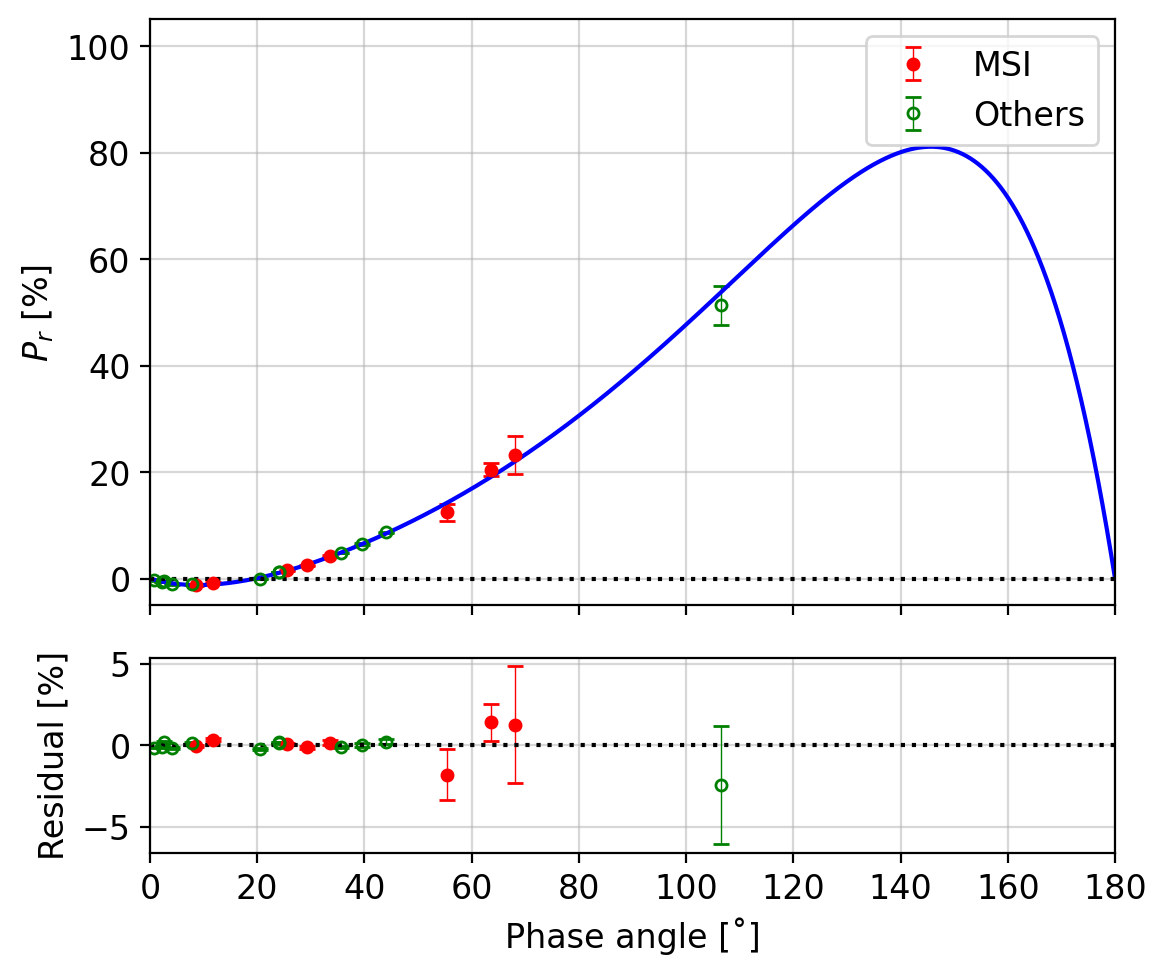

In [5]:
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(fitfunc, alpha, polr, sigma=dpolr, **cfit_kw)
print(popt)
fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True, sharey=False, gridspec_kw={'height_ratios':[3, 1]})
ax1, ax2 = axs

ax1.errorbar(alpha_msi, polr_msi, dpolr_msi, color='r', **errbfmt, label="MSI")
ax1.errorbar(alpha_oth, polr_oth, dpolr_oth, color='g', mfc='none', **errbfmt, label="Others")
ax1.plot(xx, fitfunc(xx, *popt), 'b-')
ax1.legend()

# popt_msi, _ = curve_fit(fitfunc, alpha_msi, polr_msi, sigma=dpolr_msi, **cfit_kw)
# popt_oth, _ = curve_fit(fitfunc, alpha_oth, polr_oth, sigma=dpolr_oth, **cfit_kw)
# ax1.plot(xx, fitfunc(xx, *popt_msi), 'r:')
# ax1.plot(xx, fitfunc(xx, *popt_oth), 'g--')

ax2.errorbar(alpha_msi, polr_msi - fitfunc(alpha_msi, *popt), dpolr_msi, color='r', **errbfmt, label="MSI")
ax2.errorbar(alpha_oth, polr_oth - fitfunc(alpha_oth, *popt), dpolr_oth, color='g', mfc='none', **errbfmt, label="Others")

ax2.set(xlabel="Phase angle [˚]", ylabel="Residual [%]", xlim=(0, 180))
ax1.set(ylabel=r"$ P_r $ [%]", ylim=(-5, 105))
[aa.axhline(0, color='k', ls=':') for aa in axs.flatten()]

yvu.linticker(axs)
plt.tight_layout()

plt.savefig(SAVEPATH / "Shestopalov-observation-fit.png")
plt.savefig(SAVEPATH / "Shestopalov-observation-fit.pdf")

Simple least-square fit will give the following best-fit parameters with the diagonal components as the variance of parameters when the $\chi^2$ contour are N-D ellipse (which is not used for error analysis):

In [6]:
popt, pcov = curve_fit(fitfunc, alpha, polr, sigma=dpolr, **cfit_kw)
amin, Pmin = min_func(np.arange(0, 20, 0.01), *popt)
amax, Pmax = max_func(np.arange(80, 130, 0.01), *popt)

# print("Least Square Fit with Scipy curve_fit\n")
# print("h[%/˚]  a0[˚]    k1[1/˚]  k2[1/˚]  k0[1/˚]")
# print(f"{popt[0]:.4f}  {popt[1]:.4f}   {popt[2]:.4f}   {popt[3]:.4f}   {popt[4]:.4f}\n")

# print("Elliptical Approximation Errors of above")
# print("{:.4f}  {:.4f}    {:.4f}   {:.4f}   {:.4f}\n".format(*np.sqrt(np.diag(pcov))))

# print("amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
# print(f"{amin:.2f}     {Pmin:.2f}    {amax:.2f}   {Pmax:.2f}")

### 4-2. MCMC with ``pymc3``
Now that we got some clue about the initial parameters, do MCMC.

I assume all the parameters follow **uniform prior**, but only the lower/upper bounds of the parameters are subjectively set. 


Run pymc3 for MCMC simulation:

In [7]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', pars['h'].low, pars['h'].upp)
    a0 = pm.Uniform('a0', pars['a0'].low, pars['a0'].upp)
    k1 = pm.Uniform('k1', pars['k1'].low, pars['k1'].upp)
    k2 = pm.Uniform('k2', pars['k2'].low, pars['k2'].upp)
    k0 = pm.Uniform('k0', pars['k0'].low, pars['k0'].upp)

    sigma = theano.shared(np.asarray(dpolr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h
             * (1 - exp(-k1*alpha))/(1 - exp(-k1*a0))
             * (1 - exp(-k0*(alpha - a0)))/k0
             * (1 - exp(-k2*(alpha - 180)))/(1 - exp(-k2*(a0 - 180)))
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=polr)
    start = {}
    for name, par in pars.items():
        start[name] = par.p0
    
    trace = pm.sample(20000, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k0, k2, k1, a0, h]
Sampling 4 chains, 38,054 divergences: 100%|██████████| 82000/82000 [02:36<00:00, 524.05draws/s]
There were 11569 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10038 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8525 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7921 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


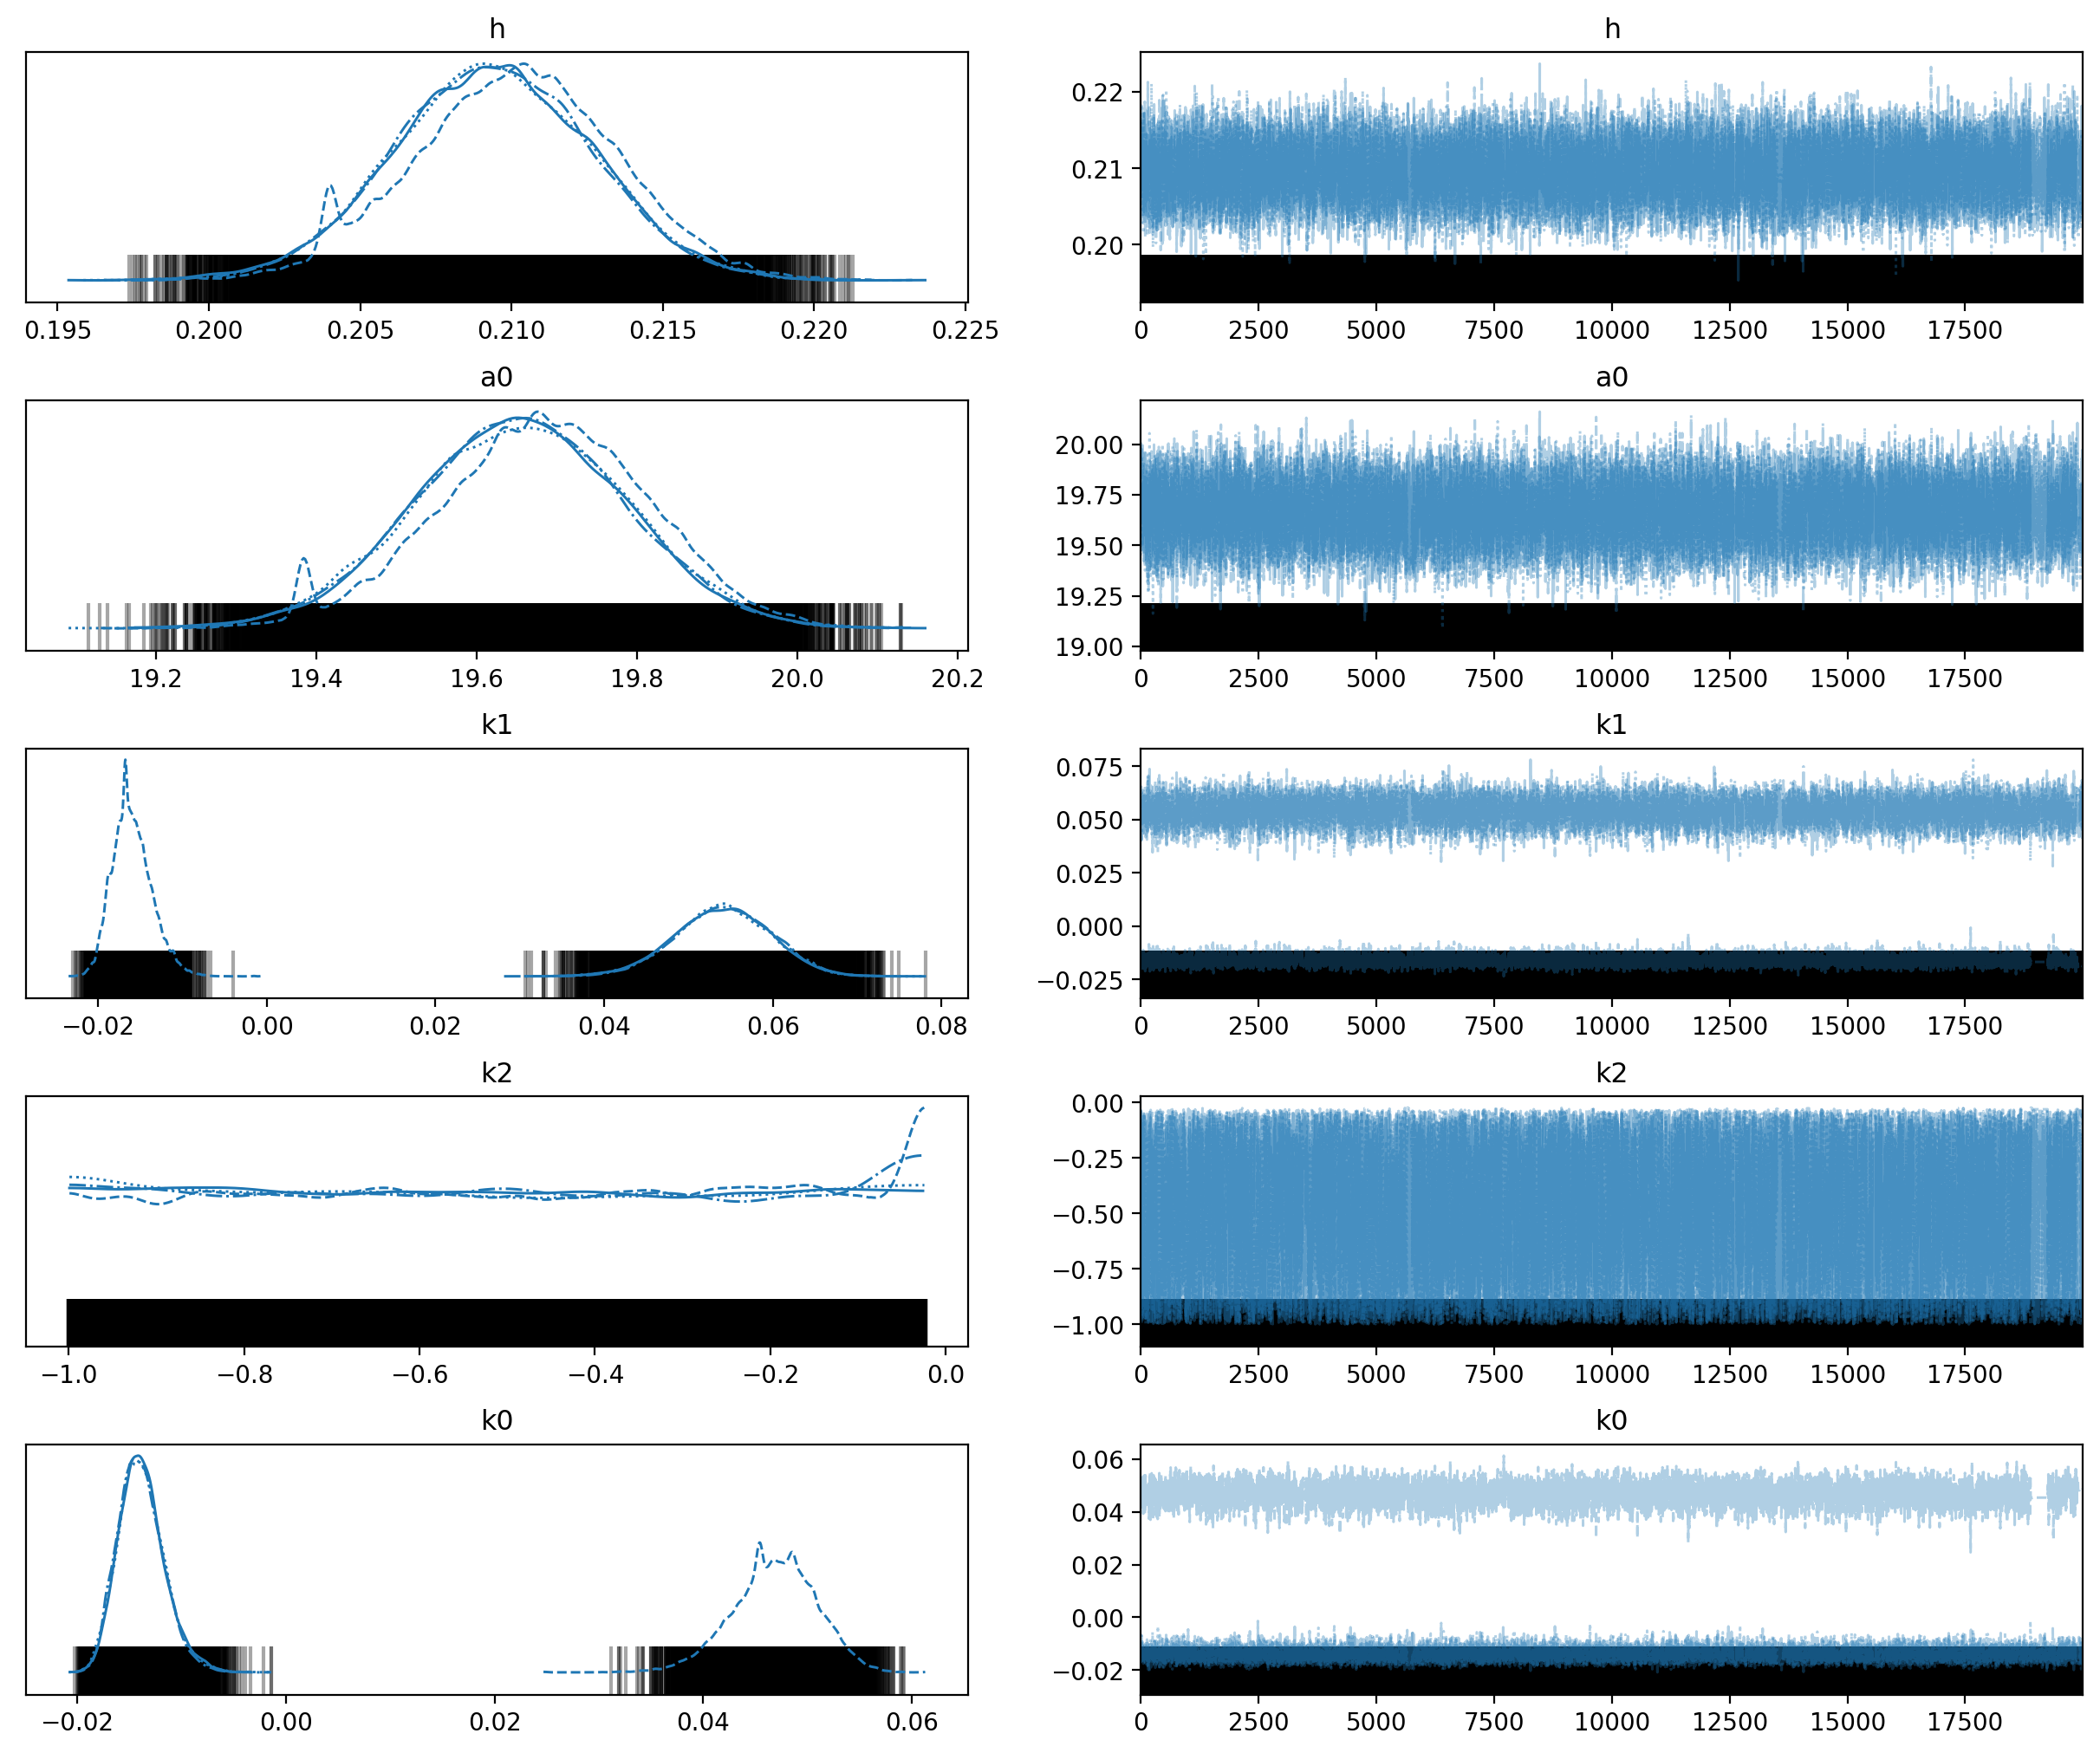

In [8]:
pm.traceplot(trace)
plt.savefig(SAVEPATH / "Shestopalov-trace.png", dpi=300)
plt.savefig(SAVEPATH / "Shestopalov-trace.pdf")

As can be seen, the trace looks very good except for c2. (see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect008.htm#statug.introbayes.bayesvisual))

The trace plot shows the "trace" of the Monte Carlo traces of the parameter space. Below I show the hpd (Highest Posterior Density) intervals for 1- and 3-sigma level are shown. 

In Bayesian sense, the posterior mean and standard deviation are used as parameter estimation and estimation error (e.g., see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect005.htm#statug.introbayes.bayesinterval)), while ``mc_error`` can be understood as an uncertainty intrinsic to this simulation due to the finite number of simulations (defined as ``sd/n_eff``). This should never be understood of the parameter uncertainty.

In [9]:
pm.summary(trace, credible_interval=0.6827).round(5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
h,0.210,0.003,0.203,0.216,0.000,0.000,5914.0,5914.0,5925.0,2413.0,1.01
a0,19.660,0.132,19.409,19.909,0.002,0.001,5870.0,5870.0,6038.0,2474.0,1.01
k1,0.037,0.031,-0.019,0.063,0.015,0.012,4.0,4.0,7.0,26.0,1.53
k2,-0.510,0.285,-0.947,-0.031,0.004,0.003,5867.0,5867.0,3894.0,1674.0,1.00
k0,0.001,0.026,-0.018,0.050,0.013,0.010,4.0,4.0,7.0,25.0,1.53


In summary, $ h = 0.216 \pm 0.003 \,[\%/^\circ] $ etc, for $ \mathrm{mean \pm std} $ notation.

In [10]:
pm.summary(trace, credible_interval=0.9973).round(5)  # 3-sigma

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
h,0.210,0.003,0.203,0.216,0.000,0.000,5914.0,5914.0,5925.0,2413.0,1.01
a0,19.660,0.132,19.409,19.909,0.002,0.001,5870.0,5870.0,6038.0,2474.0,1.01
k1,0.037,0.031,-0.019,0.063,0.015,0.012,4.0,4.0,7.0,26.0,1.53
k2,-0.510,0.285,-0.947,-0.031,0.004,0.003,5867.0,5867.0,3894.0,1674.0,1.00
k0,0.001,0.026,-0.018,0.050,0.013,0.010,4.0,4.0,7.0,25.0,1.53


In [11]:
res = []

samples = np.array([trace.get_values(k) for k in pars.keys()])
for sample in samples.T:
    res.append(shesp_min(xx, *sample))
res = np.array(res)
amin_mean, pmin_mean = np.mean(res, axis=0)
amin_sd, pmin_sd = np.std(res, axis=0, ddof=1)
print(f"a_min = {amin_mean:.4f} ± {amin_sd:.4f}")
print(f"P_min = {pmin_mean:.4f} ± {pmin_sd:.4f}")

a_min = 8.9728 ± 0.1126
P_min = -1.2203 ± 0.0311


### 4-3. Chi-Square Analysis
In the chi-square sense, what we have to do are
1. Calculate the chi-square statistic at each parameter space position. 
2. Keep only those with $\chi^2 < \chi^2_\mathrm{min} + \Delta(\nu, \alpha)$ 
    * $\Delta$: inverse cdf (cumulative distribution function) of $\chi^2$ distribution.
    * $\alpha$: significance level ($\alpha = 0.6827$ for 1-σ)
    * $\nu$: number of free parameters.
3. These are the models "within 1-sigma level confidence interval".
4. Get the min/max of each of the parameters and set these as lower/upper limit of the parameters.
5. The "center" of the parameters can be obtained by simple maximum likelihood estimation, such as least-square fitting.

Since it's difficult to sample all the 4-D paramter space, I used the traced parameter values from the MCMC above. 

Summarize for the models with 1-sigma chi-square value:

In [12]:
delta = chi2.ppf(0.6827, n_param)

n_trace = trace['h'].shape[0]
res = dict(chi2=np.zeros(n_trace),
           amax=np.zeros(n_trace), amin=np.zeros(n_trace),
           Pmax=np.zeros(n_trace), Pmin=np.zeros(n_trace))
for k in pars.keys():
    res[k] = trace[k]

do_func(alpha, polr, dpolr,
        arr_h=res["h"], arr_a0=res["a0"], arr_k1=res["k1"], arr_k2=res["k2"], 
        arr_k0=res["k0"], 
        arr_chi2=res["chi2"],
        arr_amax=res["amax"], arr_Pmax=res["Pmax"], 
        arr_amin=res["amin"], arr_Pmin=res["Pmin"])

chi2_min = res["chi2"].min()
mask_1sig = res["chi2"] < (chi2_min + delta)
# mask_1sig = res["chi2"] < (chi2_min + np.sqrt(2/(y.shape[0]-4)))

res_df = pd.DataFrame(res)
res_1sig = res_df[mask_1sig]

res_1sig.describe()

,chi2,amax,amin,Pmax,Pmin,h,a0,k1,k2,k0
count,52151.000000,5.215100e+04,52151.000000,52151.000000,52151.000000,52151.000000,52151.000000,52151.000000,52151.000000,52151.000000
mean,113.306338,1.399800e+02,8.968741,100.028670,-1.221238,0.209563,19.659513,0.039441,-0.508424,-0.001065
std,1.188371,1.803091e-10,0.085873,9.176141,0.023860,0.002545,0.102627,0.029079,0.286432,0.025073
min,109.573195,1.399800e+02,8.700000,66.669931,-1.288306,0.202444,19.367228,-0.020480,-0.999963,-0.019047
25%,112.391507,1.399800e+02,8.910000,93.591289,-1.238373,0.207727,19.585631,0.047011,-0.757729,-0.014905
50%,113.311577,1.399800e+02,8.970000,99.899393,-1.221082,0.209560,19.660586,0.052703,-0.508873,-0.013433
75%,114.267921,1.399800e+02,9.030000,106.482558,-1.203902,0.211419,19.733688,0.056589,-0.258229,-0.011076
max,115.460389,1.399800e+02,9.190000,126.687813,-1.156315,0.216481,19.931686,0.068435,-0.023333,0.054433


In [13]:
res_df.describe()

,chi2,amax,amin,Pmax,Pmin,h,a0,k1,k2,k0
count,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,114.998566,1.399800e+02,8.973120,99.665318,-1.220352,0.209540,19.659695,0.036579,-0.510004,0.001321
std,2.918090,2.731343e-10,0.108628,11.679081,0.031136,0.003310,0.132425,0.030726,0.285332,0.026409
min,109.573195,1.399800e+02,8.480000,56.053906,-1.348860,0.195336,19.089623,-0.023487,-0.999999,-0.020838
25%,112.895280,1.399800e+02,8.900000,91.715522,-1.241463,0.207297,19.570998,0.020907,-0.757507,-0.014886
50%,114.339670,1.399800e+02,8.970000,99.475048,-1.220457,0.209549,19.661154,0.051725,-0.510897,-0.013053
75%,116.414906,1.399800e+02,9.050000,107.424552,-1.199428,0.211788,19.750529,0.056557,-0.261165,0.005137
max,138.611275,1.399800e+02,9.490000,153.374394,-1.078518,0.223704,20.160360,0.078055,-0.023333,0.061317


Summarize:

In [14]:
param_tab = dict(pars=list(pars.keys()) + ["amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab["pars"]):
    pmin = res_1sig[p].min()
    pmax = res_1sig[p].max()
    p_hi = abs(pmax - param_tab["lsqs"][i])
    p_lo = abs(param_tab["lsqs"][i] - pmin)
    
    param_tab["mins"].append(pmin)
    param_tab["maxs"].append(pmax)
    param_tab["plus"].append(p_hi)
    param_tab["minus"].append(p_lo)
    
param_tab = pd.DataFrame.from_dict(param_tab)
param_tab

,pars,lsqs,plus,minus,mins,maxs
0,h,0.208159,0.008322,0.005714,0.202444,0.216481
1,a0,19.622713,0.308973,0.255485,19.367228,19.931686
2,k1,0.061617,0.006817,0.082097,-0.020480,0.068435
3,k2,-0.009785,0.013548,0.990178,-0.999963,-0.023333
4,k0,-0.023186,0.077620,0.004139,-0.019047,0.054433
5,amin,8.900000,0.290000,0.200000,8.700000,9.190000
6,Pmin,-1.220249,0.063934,0.068057,-1.288306,-1.156315
7,amax,129.980000,10.000000,10.000000,139.980000,139.980000
8,Pmax,74.543487,52.144326,7.873557,66.669931,126.687813


That is, for example, $h = 0.2165 ^{+0.0068}_{-0.0071} \,[\%/^\circ] $ such that the min/max are 0.2094 and 0.2233. (the exact value may slightly change from time to time especially the error-bars, because it's basically random sampling of finite number of samples)

Comparing the above values with the previous table's ``min`` and ``max`` of each parameter, we now have the best fit parameter and uncertainty ranges in chi-square senses.

### 4-4. Some Selected Model Plots from MCMC
Among the 80000 samples (excluding the first 2000 as burn-in phase, so that, e.g., ``len(trace.get_values['h'])`` will be 80000 not 82000), I plotted the models at every 100 index interval as black dotted line below. They're not necessarily "good" models because they are nothing but "trace".

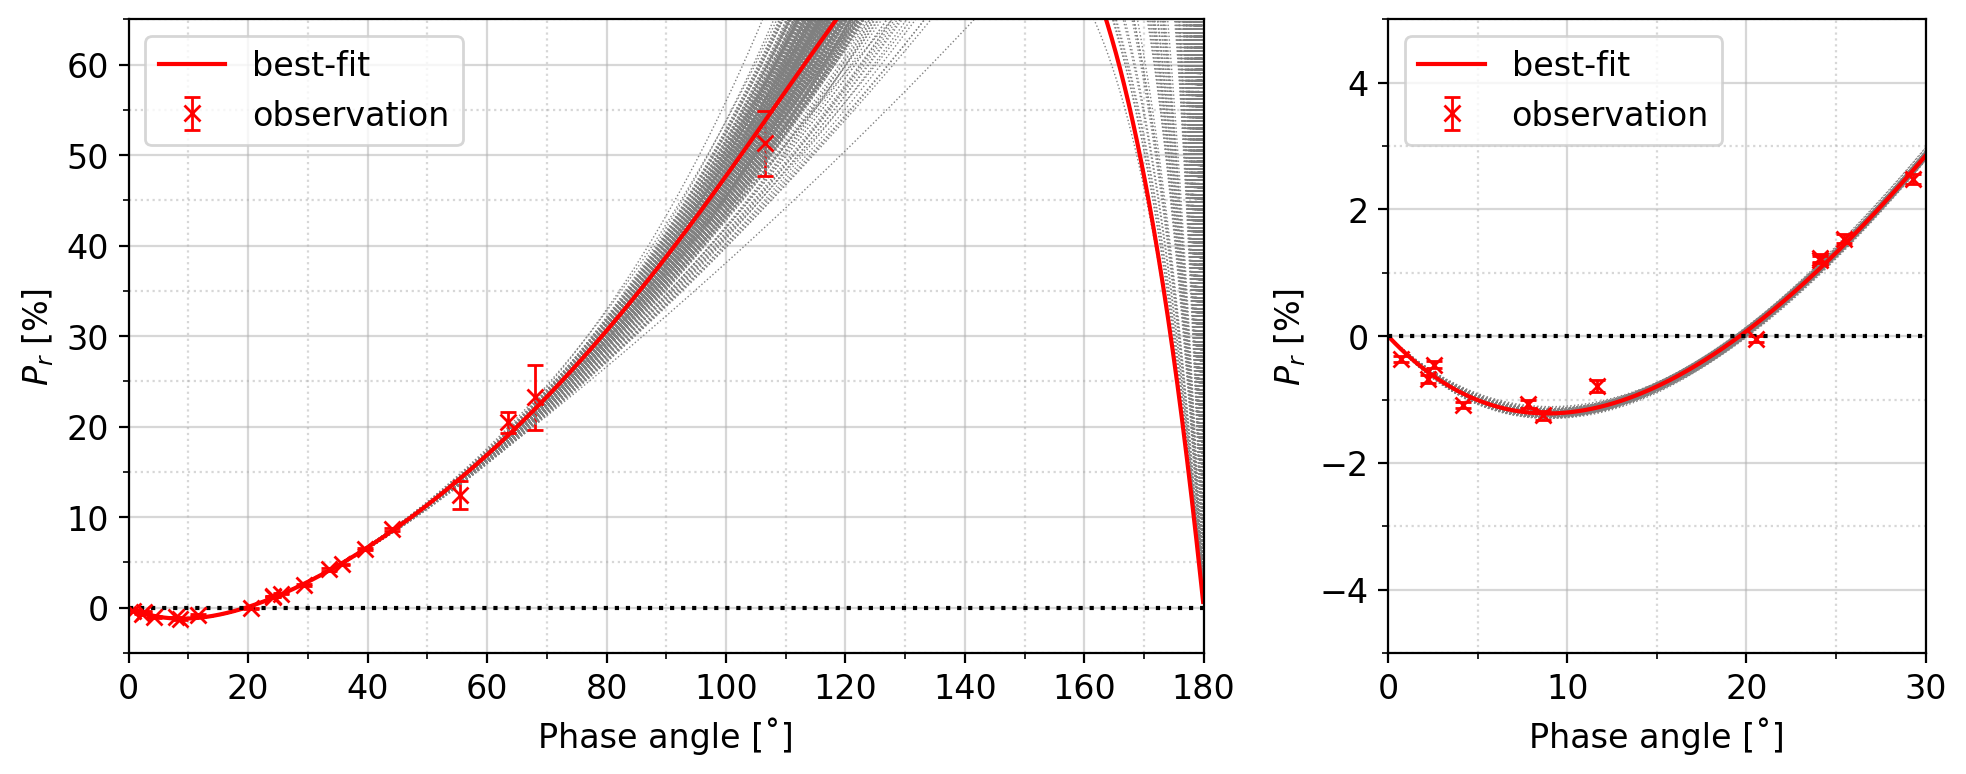

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False, 
                        gridspec_kw={'width_ratios':[2,1]})

for ax in axs.tolist():
    for j in range(0, n_trace, 200):
        ax.plot(xx, fitfunc(xx, res["h"][j], res["a0"][j], res["k1"][j], res["k2"][j], res["k0"][j]), 
                 ls=':', lw=0.5, color='grey')

    ax.errorbar(alpha, polr, dpolr, marker='x', elinewidth=1, capsize=3, color='r', ls='',
                label="observation")
    ax.plot(xx, fitfunc(xx, *popt), color='r', label="best-fit")

    ax.set_xlabel("Phase angle [˚]")
    ax.set_ylabel(r"$ P_r $ [%]")
    ax.legend(loc=2)
    ax.axhline(0, color='k', ls=':')

yvu.linticker(axs, xmajlockws=[20, 10], xminlockws=[10, 5], ymajlockws=[10, 2], yminlockws=[5, 1])
axs[0].set_xlim(0, 180)
axs[0].set_ylim(-5, 65)
axs[1].set_xlim(0, 30)
axs[1].set_ylim(-5, 5)



plt.tight_layout()
plt.savefig(SAVEPATH / "Shestopalov-observation-mcmc.png", dpi=300)
plt.savefig(SAVEPATH / "Shestopalov-observation-mcmc.pdf")

### 4-5. Pairplot of Parameters

Draw a corner plot

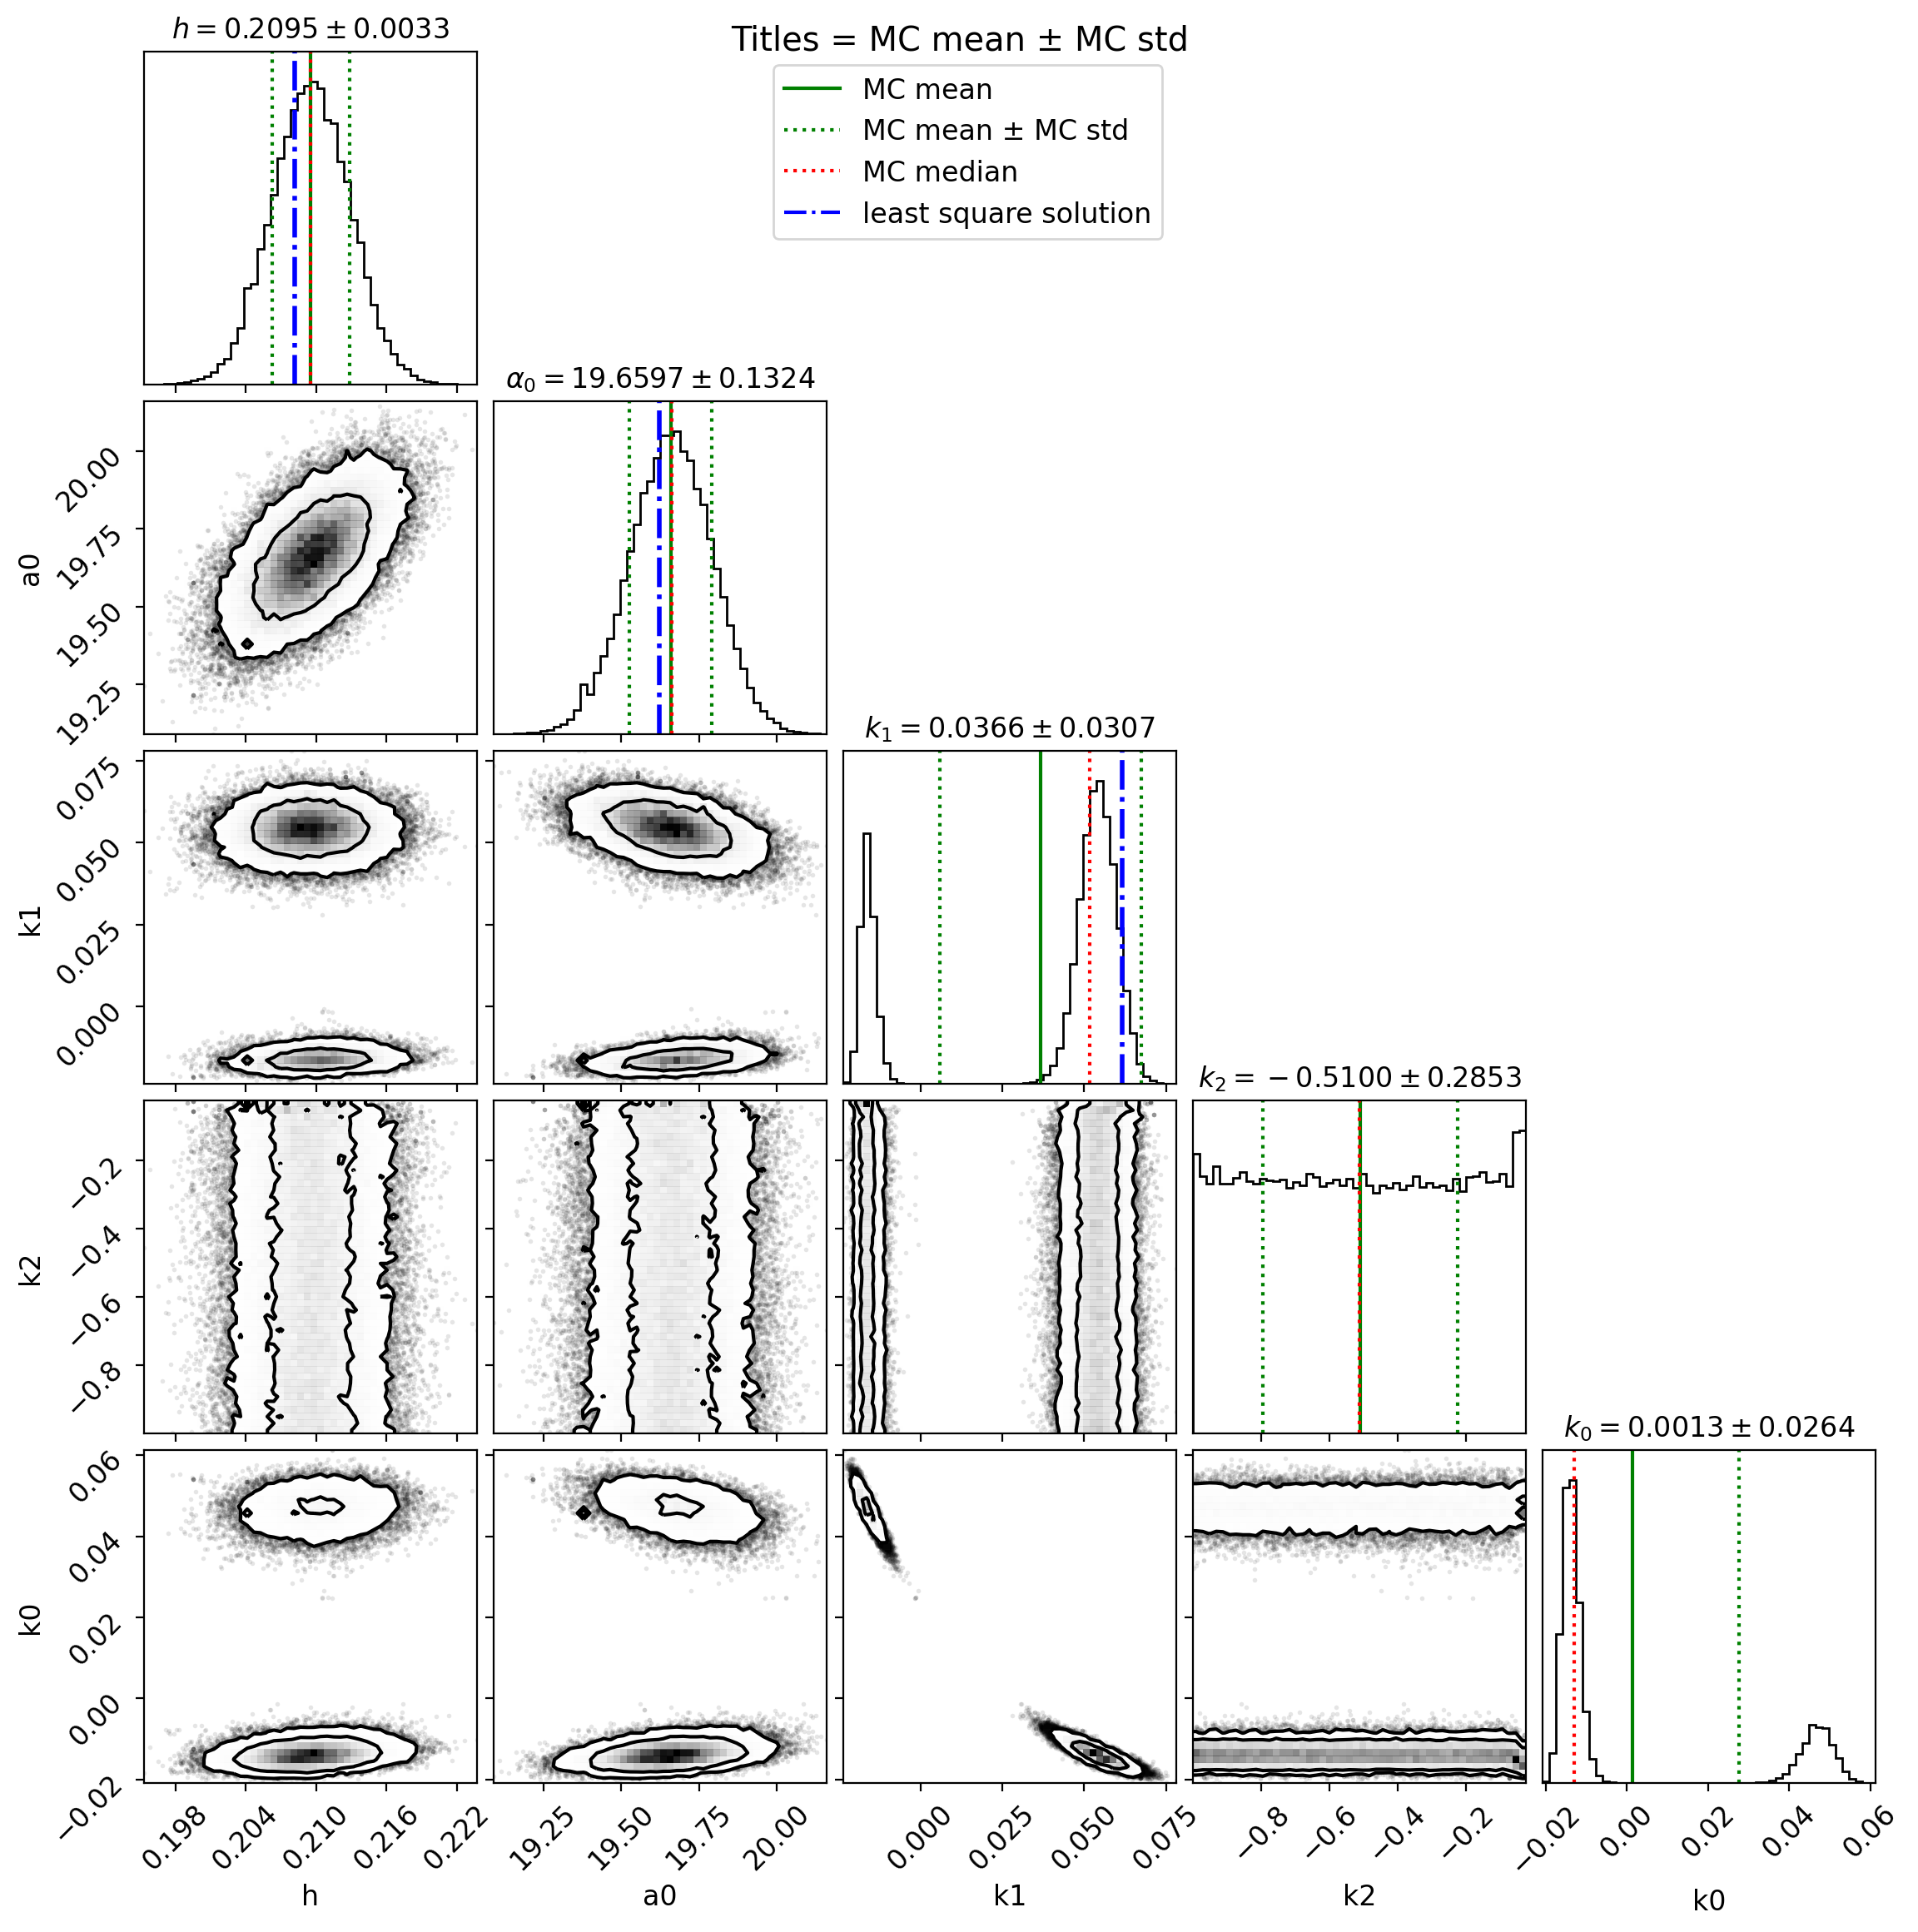

In [16]:
trace_df = pm.trace_to_dataframe(trace)
means = np.mean(trace_df, axis=0)
meds = np.median(trace_df, axis=0)
sds = np.std(trace_df, axis=0, ddof=1)
maps = popt
varnames = dict(h='h', a0='\\alpha_0', k1='k_1', k2='k_2', k0='k_0')

fig = corner.corner(trace_df, 
#                     quantiles=[0.5 - 0.6827/2, 0.5 + 0.6827/2],
                    levels=[0.6827, 0.9545], #, 0.9973
                    bins=50,
                    show_titles=False,
                    title_fmt='5.3f',
                    title_kwargs={'fontsize': 12}
                   )
axes = np.array(fig.axes).reshape((n_param, n_param))

# Loop over the diagonal
for i in range(n_param):
    ax = axes[i, i]
    ax.axvline(means[i], color="g", ls='-')
    ax.axvline(means[i] - sds[i], color="g", ls=':')
    ax.axvline(means[i] + sds[i], color="g", ls=':')
    ax.axvline(meds[i], color="r", ls=':')
    ax.axvline(maps[i], color='b', ls='-.', lw=2)
    ax.set_title(r"${} = {:4.4f} \pm {:4.4f}$".format(varnames[trace.varnames[n_param+i]],
                                                     means[i],
                                                     sds[i]
                                                    ),
                fontsize=12)

axes[0, 2].plot(np.nan, np.nan, 'g-', label='MC mean')
axes[0, 2].plot(np.nan, np.nan, 'g:', label='MC mean ± MC std')
axes[0, 2].plot(np.nan, np.nan, 'r:', label='MC median')
# axes[0, 2].plot(np.nan, np.nan, 'k--', label='MC 1-$\sigma$ percentile')
axes[0, 2].plot(np.nan, np.nan, 'b-.', label='least square solution')
axes[0, 2].legend()
        
fig.suptitle("Titles = MC mean ± MC std")
plt.savefig(SAVEPATH/"Shestopalov-corner.pdf")
plt.savefig(SAVEPATH/"Shestopalov-corner.png", dpi=300);

You may use ``seaborn`` which is extremely slow in this case:
```python
trace_df = pm.trace_to_dataframe(trace)
# sns.pairplot(,
#              kind='reg', markers='+')

g = sns.PairGrid(trace_df, diag_sharey=False)
g.map_lower(sns.kdeplot, kind='reg')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)
```

### 4-6. To LATEX Table
If you want to save the resulting table as LaTeX format, for example, you may use the following python code:

In [17]:
from astropy.io.ascii.latex import latexdicts
from astropy.table import Table, vstack

tab = Table.from_pandas(param_tab)

for c in tab.colnames:
    try:    
        tab[c].format = '.4f'
    except ValueError:
        continue

tab.write(SAVEPATH / "test.tex", format='ascii.latex', latexdict=latexdicts["AA"])

``latexdicts["AA"]`` means it is in the format of A&A. You may use ``"AA"``, ``"doublelines"``, and ``"template"``.

It has the following output:

```latex
\begin{table}
\begin{tabular}{cccccc}
\hline \hline
pars & lsqs & plus & minus & mins & maxs \\
\hline
h & 0.2082 & 0.0178 & 0.0157 & 0.1925 & 0.2261 \\
c1 & 0.8647 & 0.1625 & 0.1120 & 0.7527 & 1.0273 \\
c2 & 0.0001 & 1.2607 & 0.0000 & 0.0001 & 1.2608 \\
a0 & 20.1849 & 0.6554 & 0.6485 & 19.5364 & 20.8404 \\
amin & 9.3800 & 1.0600 & 0.9000 & 8.4800 & 10.4400 \\
Pmin & -1.1692 & 0.1446 & 0.1485 & -1.3176 & -1.0246 \\
amax & 100.8100 & 0.5500 & 16.0500 & 84.7600 & 101.3600 \\
Pmax & 29.0842 & 3.4382 & 7.5246 & 21.5596 & 32.5224 \\
\hline
\end{tabular}
\end{table}
```

You may tune it as you wish...

In [18]:
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was finished at {now} ")

This notebook was finished at 2021-03-23 14:17:26 (KST = GMT+0900) 
